## Detecting Depression from Online Text
<br>
Depression is a mood disorder that affects almost 1 in 10 Americans each year, with teens and young adults being the most affected groups (US News, 2022). Though it has reached epidemic levels, there is still no universal method of consistently screening and many caregivers such as parents, teachers, and coaches have little, if any, training in detecting signs of depression.<br><br>
Twitter, an online social media platform that allows users to write "tweets" (short messages of no more than 280 characters, has 77.75 million active users in the US as of 2022 (Statista, 2022). Given that tweets appear instantaneously once a user posts one, it can serve as a way to peer into the thoughts of a user in real time.<br><br>
For this project, I wanted to see if it would be possible to accurately predict whether or not a tweet is considered to be "depressive" or "not depressive." If we can successfully predict a dip in someone's mood in real time, then we can better provide preventative measures to help their well-being.
<br><br>
The two datasets I used from Kaggle are:
<br><br>
- Depression: Twitter Dataset + Feature Extraction, a collection of tweets from Twitter. Each post is labeled with 0 for "not depressed" and 1 for "depressed."
<br><br>
- Sentimental Analysis for Tweets, a collection of tweets from Twitter. Each post is labeled with 0 for "not depressed" and 1 for "depressed."

# EDA

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import mlflow
import pickle
import csv

### 1. Read in datasets

In [2]:
mental_health_tweets = pd.read_csv('Mental-Health-Twitter.csv', index_col=[0])
sentiment_tweets = pd.read_csv('sentiment_tweets3.csv', index_col=[0])

### 2. Preview contents and gather information about datasets

In [3]:
mental_health_tweets.info

<bound method DataFrame.info of                   post_id                    post_created  \
0      637894677824413696  Sun Aug 30 07:48:37 +0000 2015   
1      637890384576778240  Sun Aug 30 07:31:33 +0000 2015   
2      637749345908051968  Sat Aug 29 22:11:07 +0000 2015   
3      637696421077123073  Sat Aug 29 18:40:49 +0000 2015   
4      637696327485366272  Sat Aug 29 18:40:26 +0000 2015   
...                   ...                             ...   
19995  819336825231773698  Thu Jan 12 00:14:56 +0000 2017   
19996  819334654260080640  Thu Jan 12 00:06:18 +0000 2017   
19997  819334503042871297  Thu Jan 12 00:05:42 +0000 2017   
19998  819334419374899200  Thu Jan 12 00:05:22 +0000 2017   
19999  819334270825197568  Thu Jan 12 00:04:47 +0000 2017   

                                               post_text     user_id  \
0      It's just over 2 years since I was diagnosed w...  1013187241   
1      It's Sunday, I need a break, so I'm planning t...  1013187241   
2      Awake but ti

In [4]:
sentiment_tweets.info

<bound method DataFrame.info of                                        message to examine  \
Index                                                       
106     just had a real good moment. i missssssssss hi...   
217            is reading manga  http://plurk.com/p/mzp1e   
220     @comeagainjen http://twitpic.com/2y2lx - http:...   
288     @lapcat Need to send 'em to my accountant tomo...   
540         ADD ME ON MYSPACE!!!  myspace.com/LookThunder   
...                                                   ...   
802309  No Depression by G Herbo is my mood from now o...   
802310  What do you do when depression succumbs the br...   
802311  Ketamine Nasal Spray Shows Promise Against Dep...   
802312  dont mistake a bad day with depression! everyo...   
802313                                                  0   

        label (depression result)  
Index                              
106                             0  
217                             0  
220                           

### 3. Check for missing data

All 2 datasets do not have missing data.

In [5]:
mental_health_tweets.isnull().all()

post_id         False
post_created    False
post_text       False
user_id         False
followers       False
friends         False
favourites      False
statuses        False
retweets        False
label           False
dtype: bool

In [6]:
sentiment_tweets.isnull().all()

message to examine           False
label (depression result)    False
dtype: bool

### 4. Homogenize column names

Since df2 only has 2 columns 'message to examine' and 'label (depression result)', I only kept the same 2 columns from df1.

In [7]:
# specify columns to keep for d2
mental_health_tweets = mental_health_tweets[['post_text', 'label']]

# confirm columns kept are the correct ones we want
mental_health_tweets.head()

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,1
4,It’s hard to say whether packing lists are mak...,1


In [8]:
# standardize column names for df2
sentiment_tweets.columns= ['post_text', 'label']

### 5. Visualize counts of depressive and non-depressive posts

df1 is balanced, but df2 has 4 times the amount of 'non-depressed' posts as it does for 'depressed' posts.

[Text(0.5, 1.0, 'label counts for sentiment_tweets')]

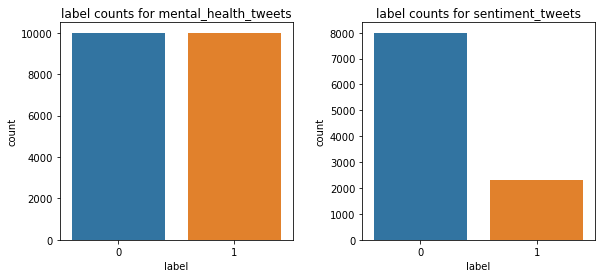

In [9]:
# set up space for figure
fig = plt.figure(figsize=(15,4))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# counts for mental_health_tweets
ax1 = fig.add_subplot(1,3,2)
sns.countplot(x='label', data=mental_health_tweets)
ax1.set(title="label counts for mental_health_tweets")

# counts for sentiment_tweets
ax2 = fig.add_subplot(1,3,3)
sns.countplot(x='label', data=sentiment_tweets)
ax2.set(title="label counts for sentiment_tweets")

In [10]:
# look at actual numbers
mental_health_tweets['label'].value_counts()
sentiment_tweets['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

### 6. Balance df2

Given that we have a large number of data from df1, I used the random undersampling method to undersample the majority class ('non-depressed') by randomly choosing samples without replacement.

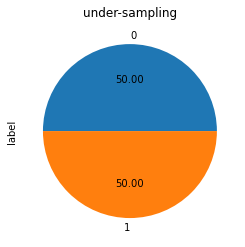

In [11]:
from imblearn.under_sampling import RandomUnderSampler
X = sentiment_tweets.drop(['label'], axis=1)
y = sentiment_tweets['label']

rus = RandomUnderSampler(sampling_strategy='not minority')
X_res, y_res = rus.fit_resample(X, y)

# visualize proportion of labels after balancing
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("under-sampling")

In [12]:
# class distribution
y_res.value_counts()

0    2314
1    2314
Name: label, dtype: int64

In [13]:
# combine columns for d3
df2 = pd.concat([X_res, y_res], axis='columns')

# confirm successful concatenation
df2.head()

# confirm balanced data
df2['label'].value_counts()

0    2314
1    2314
Name: label, dtype: int64

### 7. Combine both dfs

In [14]:
tweets = pd.concat([mental_health_tweets, sentiment_tweets])

# confirm change
tweets.shape

(30314, 2)

### 8. Explore number of words in 'depressed' and 'non-depressed' posts

Posts vary in length, so I wanted to see if there were differences in the number of words used in 'depressed' vs 'non-depressed' posts. For simplicity, I assumed that words are separated by spaces.

In [15]:
# split words in 'post-text' and count
tweets['word_count'] = tweets['post_text'].apply(lambda x: len(str(x).split()))
tweets.head()

,post_text,label,word_count
0,It's just over 2 years since I was diagnosed w...,1,26
1,"It's Sunday, I need a break, so I'm planning t...",1,19
2,Awake but tired. I need to sleep but my brain ...,1,13
3,RT @SewHQ: #Retro bears make perfect gifts and...,1,23
4,It’s hard to say whether packing lists are mak...,1,21


Most posts in general tend to be on the shorter end, with depressed posts averaging 15 words versus non-depressed posts averaging 12 words.
<br><br>
The distribution of word counts for non-depressed posts is slightly right-skewed (min: 1, max: 34) and the distribution of word counts for depressed counts is heavily right-skewed (min: 1, max: 92).

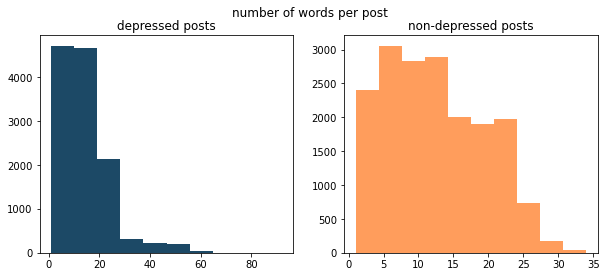

In [16]:
# plot number of words in 'depressed' and 'non-depressed' posts
fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

dep_words = tweets[tweets['label'] == 1]['word_count']
ax1.hist(dep_words,color='#1c4966')
ax1.set_title('depressed posts')

non_dep_words = tweets[tweets['label'] == 0]['word_count']
ax2.hist(non_dep_words, color = '#ff9d5c')
ax2.set_title('non-depressed posts')

fig.suptitle('number of words per post')
plt.show()

In [17]:
print('The minimum number of words in non-depressed posts is: ', non_dep_words.min())
print('The maximum number of words in non-depressed posts is: ', non_dep_words.max())
print('___________________________________________________________')
print('The minimum number of words in depressed posts is: ', dep_words.min())
print('The maximum number of words in non-depressed posts is: ', dep_words.max())
print('___________________________________________________________')
print('The average number of words in non-depressed posts is: ', round(non_dep_words.mean()))
print('The average number of words in depressed posts is: ', round(dep_words.mean()))

The minimum number of words in non-depressed posts is:  1
The maximum number of words in non-depressed posts is:  34
___________________________________________________________
The minimum number of words in depressed posts is:  1
The maximum number of words in non-depressed posts is:  92
___________________________________________________________
The average number of words in non-depressed posts is:  12
The average number of words in depressed posts is:  15


### 9. Split dataset into train and test sets

To avoid data leakage, I split the dataset into train (80%) and test (20%) sets before any pre-processing or normalization/transformation steps.

In [18]:
from sklearn.model_selection import train_test_split

# split into training and testing site with 20% of rows going to testing and 80% going to training
# random state of 10 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(tweets['post_text'], tweets['label'], test_size = 0.2, random_state = 10)

print(f"Number of training: {X_train.shape[0]}")
print(f"Number of testing: {X_test.shape[0]}")

Number of training: 24251
Number of testing: 6063


# Pre-process

### 10. Clean text

Prior to building our model, we need to pre-process the text. This involves lemmatizing words and removing stop words, extra white spaces, links, punctuations and special characters.
<br><br>
Since our posts were scraped from the web, there may be some HTML tags embedded in them, which would not be helpful to us. I used Beautiful Soup to remove HTML tags.
<br><br>
I made all the text lowercase and removed punctuations. Stopwords are common words that are not typically useful for NLP. Since we won't be needing them, I also removed them.
<br><br>
Finally, since many words have various forms, I wanted to convert each word to its base form. For this task, the two most common methods are stemming and lemmatization.
<br><br>
Stemming chops off affixes (prefixes/suffixes) of words and can sometimes convert words into something unrecognizable. However, this method tends to be faster. Lemmatization casts words to their root forms and is more involved than stemming since this method needs to know the part of speech for each word, hence would take longer than stemming. 
Since our data isn't horribly large and time/cost are not major concerns, I chose to lemmantization over stemming.

In [19]:
from bs4 import BeautifulSoup

# create stepwise cleaning function
def preprocess(text):
    
    # lowercase text
    text = text.lower()
    
    # strip all excess white space
    text = text.strip()
    
    # strip HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text(separator = ' ')
    
    # remove retweets
    text = re.sub('rt @[\w_]+:','', text)
    
    # remove hyperlinks
    text = re.sub(r'http\S+','', text)
    
    # remove escape sequences
    text = re.sub(r'\n','', text)
    
    # remove punctuations
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    
    return text

In [20]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# remove stopwords
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    text_no_stop = [word for word in word_tokens if word not in stop_words]
    return text_no_stop

In [21]:
from nltk.stem import WordNetLemmatizer

# lemmatize
def lemmatize_text(list_of_tokenized_words):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in list_of_tokenized_words]
    return lemmatized

In [22]:
# put it all together
def final_preprocess(text):
    return preprocess(remove_stopwords(lemmatize_text(text)))
    
# pre-process training data
X_train_clean = [preprocess(text) for text in X_train]

# Text Modeling

### 11. Tokenize text and Calculate TF-IDF

Prior to running any machine learning models, text data must be converted into numerical feauture vectors.<br><br>
CountVectorizer() tokenizes and counts and TfidfTransformer() normalizes the data by providing the importance of the words. TfidfVectorizer() is able to do all 3 tasks.<br><br>
TF-IDF (term frequency-inverse document frequency) divides the count of each word by the total count of words in a document ('TF' part) and then lowers the weight of words that occur most frequently while increasing the weight of words that are less frequent ('IDF' part). 

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize
tfidf_vectorizer = TfidfVectorizer(min_df = 0.0003)
tfidf_vec_matrix = tfidf_vectorizer.fit_transform(X_train_clean)
feature_names = tfidf_vectorizer.get_feature_names_out()

# create dense matrix and convert to dataframe
dense_mtx = tfidf_vec_matrix.todense()
dense_lst = dense_mtx.tolist()
tfidf_df = pd.DataFrame(dense_lst, columns = feature_names)
tfidf_df.head()

,00,000,08,10,100,1000,11,12,13,14,...,yr,yrs,yum,yummy,yup,zayin,zayn,zaynmalik,zenhabits,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 12. Create word cloud

Word clouds are popular visualizations for NLP projects since they are a quick way to see the most common words in a document. Words are dispalyed in varying sizes -- the larger the word, the more it appears in the text and the smaller the word, the less it appears in the text.
<br><br>
While I'm not typically a fan of word clouds, I thought they would be particularly interesting to use here to visually compare the most common words used in 'depressed' verses 'not depressed' posts.

In [24]:
from wordcloud import WordCloud

# make dataframe with cleaned posts and labels
word_cloud_dict = {'text': X_train_clean, 'label': y_train}
word_cloud_df = pd.DataFrame.from_dict(word_cloud_dict)
print(word_cloud_df)

# split into 'depressed' and 'not depressed' groups
word_cloud_dep = word_cloud_df[word_cloud_df['label'] == 1]
word_cloud_not_dep = word_cloud_df[word_cloud_df['label'] == 0]

                                                     text  label
10562    kj apa it does but you re coming back to your...      0
14856   oh facebook dms have been triggering me for th...      0
13968                                       i am the duff      0
12996    nbcnews told putin what a numb evil murderer ...      0
12909    wsjsolomon netanyahu does god know you ve los...      0
...                                                   ...    ...
800017  how to heal anxiety depression and fibromyalgi...      1
17728                                19 joanne 87 agreed       0
801199  spending the day with mr chapmangl at grasslak...      1
7293     whether you like obama as a president or not ...      1
17673                         i swear to god i hate kyrie      0

[24251 rows x 2 columns]


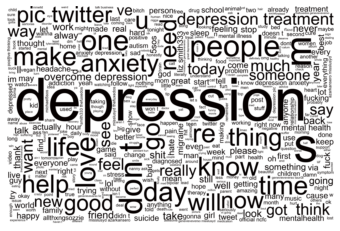

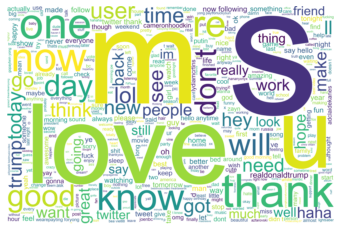

In [25]:
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

# generate 'depressed' word cloud
dep_cloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color = "white", width = 3000, height = 2000, max_words = 500).generate(' '.join(word_cloud_dep['text']))

# set the word color to black
dep_cloud.recolor(color_func = black_color_func)

plt.imshow(dep_cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# generate 'not depressed' word cloud
dep_cloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color = "white", width = 3000, height = 2000, max_words = 500).generate(' '.join(word_cloud_not_dep['text']))

plt.imshow(dep_cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

Some words that stand out for the 'depressed' posts are "depression", "anxiety", "depression treatment", "help", "love", "think", and "time" while the words that stand out for the 'not depressed' posts are "user", "love" (notice that love is more frequently encountered in 'not depressed' posts), "thank", "know", "one, "good", "trump" and "people".
<br><br>
Both word clouds are helpful in giving us insight on the general "vibe" of 'depressed' and 'not depressed' posts.

### 13. Train classifier and Evaluate Performance

##### i. Multinomial Naive Bayes
Multinomial Naive Bayes is often used in text classification problems and assumes that observations follow the multinomial distribution which describes the probability of observing counts among 3 or more categories. 
<br><br>
It's based on the Bayes theorem and predicts the label of each piece of text based on previously labeled words. Basically, for any given word in a document, we count the frequency of that word and see how many times it belongs in each category (ie. 'depressed' or 'not depressed'), then we divide it by all the words that belong to that document -- and that'll give us the probability for that word belonging in each category.
<br><br>
The Naive Bayes classifier is fast for both training and prediction and is easy to interpret, which makes it a good initial baseline.

##### ii. Support Vector Machine
Support Vector Machine (SVM) is used in both classification and regression models. Its goal is to find the best hyperplane that can separate data into different classes by maximizing the margins of the closest data points for each class.
<br><br>
The kernel function allows SVM to have the flexibility to work with both linear and non-linear data by transforming the data to become lineraly separable.
<br><br>
SVM is able to handle noisy and high-dimensional data but can be computationally expensive and may need careful selection of hyperparameters to get good results.

##### iii. Logistic Regression
Logistic Regression is used for binary classification and works by using a logistic function to output a probability value between 0 and 1 for a data point.
<br><br>
Advantages for this model includes simplicity, speed, and interpretability. However, due to its linear nature, it may not perform as well in more complex situations.

##### iv. Performance Evaluation
A confusion matrix is used to evaluate the performance of a classification model by comparing the number of correctly and incorrecty labeled predictions. It has four quadrants -- True Positive (correctly labeled positive class), False Positive (incorrectly labeled positive class), True Negative (correctly labeled negative class), and False Negative (incorrectly labeled negative class).
<br><br>
Accuracy is the proportion of correctly labeled predictions.
<br><br>
Precision is the proportion of true positives from all positive predictions.
<br><br>
Recall is the proportion of true positives among all real positive labels.
<br><br>
F1 score is the weighted average of precision and recall.
<br><br>
By analyzing our confusion matrices, we can identify the type of errors from our models.

In [26]:
# preprocess testing data
X_test_clean = [preprocess(text) for text in X_test]

# vectorize testing data
X_test_tfidf_vec_matrix = tfidf_vectorizer.transform(X_test_clean)

Multinomial Naive Bayes
Accuracy: 0.8172521853867722
Precision: 0.8711918760021379
Recall: 0.6527833400080096
F1 score: 0.7463369963369964


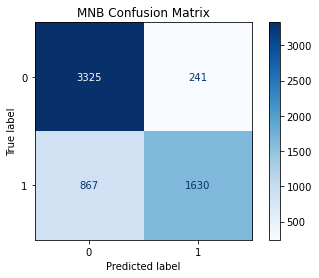

SVM
Accuracy: 0.8210456869536533
Precision: 0.8979706877113867
Recall: 0.6379655586704045
F1 score: 0.7459611332240693


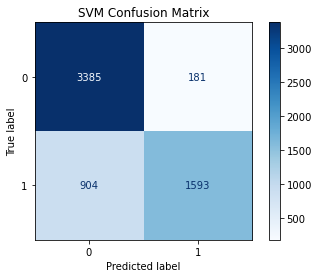

Logistic Regression
Accuracy: 0.8162625762823684
Precision: 0.8789041095890411
Recall: 0.6423708450140169
F1 score: 0.7422489588153632


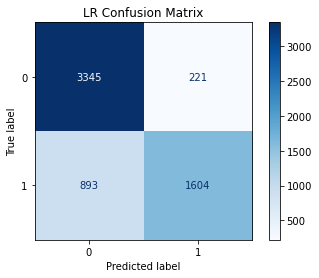

In [37]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression

# classification function to fit, predict, and evaluate performance
def classifier(clf, tfidf_vec_matrix, y_train, name, cm_title, saved_file, csv_name):
    # fit
    clf.fit(tfidf_vec_matrix, y_train)

    # predict
    y_pred = clf.predict(X_test_tfidf_vec_matrix)

    # evaluate performance
    print(name)
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
    print('Precision:', metrics.precision_score(y_test, y_pred))
    print('Recall:', metrics.recall_score(y_test, y_pred))
    print('F1 score:', metrics.f1_score(y_test, y_pred))

    # run confusion matrix
    confusion_matrix(y_test, y_pred)

    # plot confusion matrix
    confusion = ConfusionMatrixDisplay.from_estimator(clf, X_test_tfidf_vec_matrix, y_test, cmap = plt.cm.Blues)
    confusion.ax_.set_title(cm_title)
    plt.show()

    # save model
    filename = saved_file
    pickle.dump(clf, open(filename, 'wb'))

    # save run results as csv
    row_list = [['Model', 'Accuracy', 'Precision', 'F1 score'],
                [name, metrics.accuracy_score(y_test, y_pred),
                 metrics.precision_score(y_test, y_pred),
                 metrics.recall_score(y_test, y_pred),
                 metrics.f1_score(y_test, y_pred)]]
    
    with open(csv_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(row_list)

# the models we want to use
mnb_clf = MultinomialNB()
lr_clf = LogisticRegression()
svm_clf = svm.SVC(kernel = 'linear')

clf_lst = [('Multinomial Naive Bayes', mnb_clf, 'MNB Confusion Matrix', 'mnb_model.sav', 'mnb_model.csv'),
           ('SVM', svm_clf, 'SVM Confusion Matrix', 'svm_model.sav', 'svm_model.csv'),
           ('Logistic Regression', lr_clf, 'LR Confusion Matrix', 'lr_model.sav', 'lr_model.csv')]
for name, clf, cm_title, saved_file, csv_name in clf_lst:
    classifier(clf, tfidf_vec_matrix, y_train, name, cm_title, saved_file, csv_name)


All models produced similar results in terms of accuracy. The SVM and Logistic Regression models were slightly better than the Multinomial Naive Bayes when it came to precision.
<br><br>
Given the reason behind this project — to provide support to those who may be depressed — it’s most important to capture as many ‘depressed’ cases as possible.
<br><br>
Most models will have some varying degree of false positive cases and false negative cases. Since we want to capture the highest number of people who may be depressed, the MNB model would be most ideal with the highest number of true positives and lowest number of false negatives.